# Quantum Many-Body Scars and Non-Ergodic Dynamics

See: 
Turner, C.J., Michailidis, A.A., Abanin, D.A. et al. Weak ergodicity breaking from quantum many-body scars. Nature Phys 14, 745–749 (2018). https://doi.org/10.1038/s41567-018-0137-5
[https://www.nature.com/articles/s41567-018-0137-5](https://www.nature.com/articles/s41567-018-0137-5)

This notebook will reconstruct the behaviour demonstrated in Fig. 2.

Quantum many-body scars are a phenomenon where a small set of atypical eigenstates within an otherwise thermalizing system lead to long-lived oscillations in dynamics, defying conventional ergodicity. Unlike many-body localization, which relies on disorder to prevent thermalization, these scars emerge in translation-invariant systems and cause the system to retain memory of its initial state for unexpectedly long times.

This notebook implements a key early result in the study of quantum many-body scars, where a specific interacting Hamiltonian exhibits long-time oscillations when initialized in a period-2 charge density wave state. The recurrence of local observables and entanglement entropy oscillations suggest the presence of special eigenstates embedded in the spectrum.

The Hamiltonian describes an interacting quantum system with constrained dynamics. It is given by:  

$$
H = \sum_{i} P^z_{i} X_{i+1} P^z_{i+2}
$$

where:  
- $X_{i}$ is the Pauli-X operator acting on site $i$, which flips the state of a qubit.  
- $P^z_{i} = \frac{1 + Z_i}{2}$ is a projector that enforces a constraint on site $i$, involving the Pauli-Z operator (note a sign difference from the paper due to different basis state conventions)

This Hamiltonian describes a system where spins (qubits) interact in a constrained way, meaning that spin flips (\(X\) terms) only occur when specific neighboring conditions are met (enforced by the $P^z$ projectors).  

## Initial States and the Scarred Dynamics  

A key observation in the study of quantum many-body scars is that certain initial states exhibit long-time oscillations instead of thermalizing. One such state is the **period-2 charge density wave** (CDW), defined as:  

$$
\left| \mathbb{Z}_2 \right\rangle = \left| 101010\cdots \right\rangle
$$

where "1" represents an excited atom (spin-up) and "0" represents the ground state (spin-down). When evolving this state under the Hamiltonian, we observe periodic revivals in local observables and entanglement entropy, instead of the system fully thermalizing as expected in most quantum chaotic systems.  

## Why This Happens: Many-Body Scars  

Instead of having all eigenstates behave chaotically (ergodically), this system contains **special eigenstates** that are evenly spaced in energy and have an anomalously low entanglement entropy. These states lead to **non-ergodic** dynamics where the system oscillates between specific configurations instead of reaching thermal equilibrium.  

## Implementation in Code  

- The function `site(i, L)` constructs the local interaction term $P^z_{i} X_{i+1} P^z_{i+2}$.  
- The term `zk_gate` initializes the system in a charge density wave state.  
- The Hamiltonian `hamiltonian` is built as a sum over all sites.  
- The circuit then simulates time evolution using quantum gates based on the Hamiltonian.  

This implementation numerically reproduces the long-lived oscillations observed in quantum many-body scars.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import itertools
import operator
from rich.pretty import pprint

import warnings
warnings.filterwarnings("ignore")

from oqd_core.interface.analog.operator import PauliI, PauliX, PauliZ
from oqd_core.interface.analog.operation import AnalogCircuit, AnalogGate
from oqd_core.backend.metric import Expectation, EntanglementEntropyVN
from oqd_core.backend.task import Task, TaskArgsAnalog
from oqd_compiler_infrastructure.rule import PrettyPrint
from oqd_compiler_infrastructure.walk import Post
from oqd_core.compiler.analog.utils import PrintOperator
from oqd_core.compiler.analog.passes.canonicalize import analog_operator_canonicalization 

from oqd_analog_emulator.qutip_backend import QutipBackend

In [3]:
def sum(args):
    return functools.reduce(operator.add, args)

def prod(args):
    return functools.reduce(operator.mul, args)

def tensor(args):
    return functools.reduce(operator.matmul, args)

In [4]:
def site(i: int, L: int):
    term = [PauliI() for j in range(L)]
    term[i] = (PauliI() + PauliZ()) * 0.5
    term[(i + 1) % L] = PauliX()
    term[(i + 2) % L] = (PauliI() + PauliZ()) * 0.5
    return tensor(term)

In [5]:
n = 12
k = 2
zk_gate = sum([tensor([PauliX() if j%k == 0 else PauliI() for j in range(n)])])

hamiltonian = sum([site(i, n) for i in range(n)])
fstring = Post(PrintOperator())
print(f"Zk gate: {fstring(zk_gate)}\nHamlitonian: {fstring(hamiltonian)}")

Zk gate: PauliX() @ PauliI() @ PauliX() @ PauliI() @ PauliX() @ PauliI() @ PauliX() @ PauliI() @ PauliX() @ PauliI() @ PauliX() @ PauliI()
Hamlitonian: ((0.5) * (PauliI() + PauliZ())) @ PauliX() @ ((0.5) * (PauliI() + PauliZ())) @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() + PauliI() @ ((0.5) * (PauliI() + PauliZ())) @ PauliX() @ ((0.5) * (PauliI() + PauliZ())) @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() + PauliI() @ PauliI() @ ((0.5) * (PauliI() + PauliZ())) @ PauliX() @ ((0.5) * (PauliI() + PauliZ())) @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() + PauliI() @ PauliI() @ PauliI() @ ((0.5) * (PauliI() + PauliZ())) @ PauliX() @ ((0.5) * (PauliI() + PauliZ())) @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() @ PauliI() + PauliI() @ PauliI() @ PauliI() @ PauliI() @ ((0.5) * (PauliI() + PauliZ())) @ PauliX() @ ((0.5) * (PauliI() + PauliZ())) @ PauliI() @ Pa

In [7]:
circuit = AnalogCircuit()
circuit.evolve(duration=np.pi/2, gate=AnalogGate(hamiltonian=zk_gate))
circuit.evolve(duration=10, gate=AnalogGate(hamiltonian=hamiltonian))
circuit.measure()

In [8]:
args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=1,
    metrics={
        f"Z_{i}": Expectation(operator=tensor([PauliZ() if j in (i, (i+1)%n) else PauliI() for j in range(n)]))
        for i in range(n)
    } | {"S": EntanglementEntropyVN(qreg=list(range(n//2)))},
    dt=1e-2,
)
task = Task(program=circuit, args=args)

backend = QutipBackend()
results = backend.run(task=task)

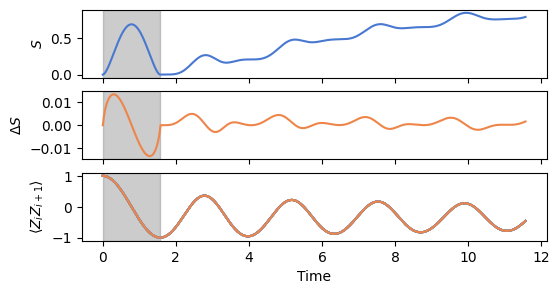

In [9]:
fig, axs = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=[6, 3])
colors = sns.color_palette(palette="muted", n_colors=max([20, n]))

axs[0].plot(results.times, results.metrics['S'], label=f"$S$", color=colors[0])
axs[1].plot(results.times, np.diff(results.metrics['S'], prepend=0.0), label=f"$S$", color=colors[1])

expectations = {metric: value for (metric, value) in results.metrics.items() if 'Z' in metric}
for k, (name, metric) in enumerate(expectations.items()):
    axs[2].plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])

for ax in axs:
    ax.axvspan(0, np.pi/2, color="gray", alpha=0.4)

axs[0].set(ylabel=r"$S$")
axs[1].set(ylabel=r"$\Delta S$")
axs[2].set(ylabel=r"$\langle Z_i Z_{i+1} \rangle$")
axs[-1].set(xlabel="Time");